In [1]:
!pip install tensorflow-probability

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [3]:
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 1)
])

NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                64        
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [4]:
optm = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [5]:
def ode_system(t, net):
    t = t.reshape(-1,1)
    t = tf.constant(t, dtype = tf.float32)    
    t_0 = tf.zeros((1,1))
    one = tf.ones((1,1))   
    
    with tf.GradientTape() as tape:
        tape.watch(t)
                    
        u = net(t)
        u_t = tape.gradient(u, t)
    
    ode_loss = u_t - tf.math.cos(2*np.pi*t) 
    IC_loss = net(t_0) - one
    
    square_loss = tf.square(ode_loss) + tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)
    
    return total_loss

1.4277714
0.3691532
0.18085061
0.105243094
0.04920905
0.0008028679


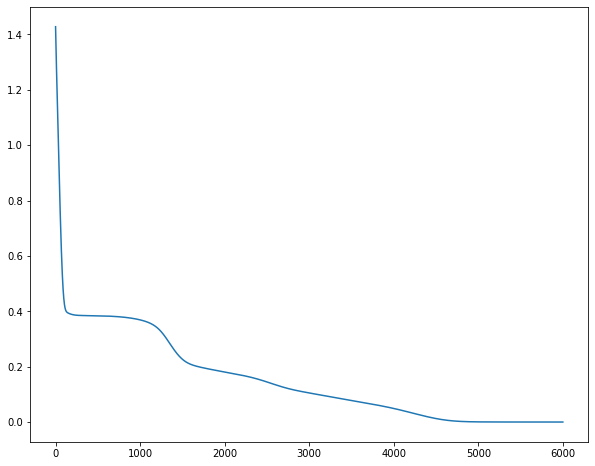

In [6]:
train_t = (np.random.rand(30)*2).reshape(-1, 1)
train_loss_record = []

for itr in range(6000):
    with tf.GradientTape() as tape:
        train_loss = ode_system(train_t, NN)
        train_loss_record.append(train_loss)
                
        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))
    
    if itr % 1000 == 0:
        print(train_loss.numpy())
        
plt.figure(figsize = (10,8))
plt.plot(train_loss_record)
plt.show()

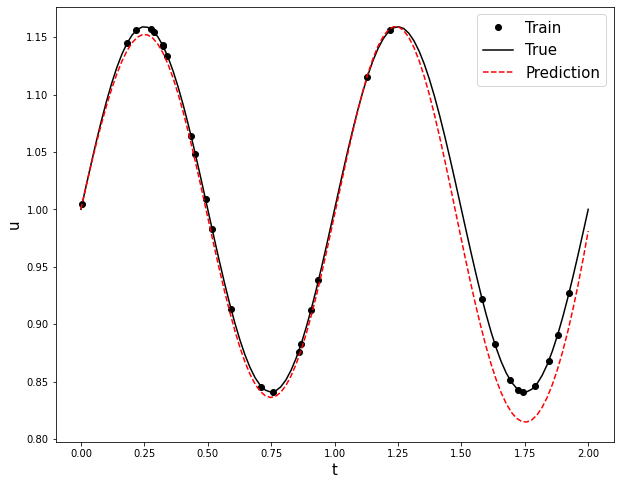

In [7]:
test_t = np.linspace(0, 2, 100)

train_u = np.sin(2*np.pi*train_t)/(2*np.pi) + 1
true_u = np.sin(2*np.pi*test_t)/(2*np.pi) + 1
pred_u = NN.predict(test_t).ravel()

plt.figure(figsize = (10,8))
plt.plot(train_t, train_u, 'ok', label = 'Train')
plt.plot(test_t, true_u, '-k',label = 'True')
plt.plot(test_t, pred_u, '--r', label = 'Prediction')
plt.legend(fontsize = 15)
plt.xlabel('t', fontsize = 15)
plt.ylabel('u', fontsize = 15)
plt.show()

In [8]:
!pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 141 kB 10.3 MB/s 
     |████████████████████████████████| 100 kB 8.7 MB/s 


In [9]:
from deepxde.backend.set_default_backend import set_default_backend
set_default_backend("tensorflow")

DeepXDE backend not selected or invalid. Use tensorflow.compat.v1.
Using backend: tensorflow.compat.v1

Instructions for updating:
non-resource variables are not supported in the long term


Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Enable just-in-time compilation with XLA.



Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [10]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import math as m

In [11]:
pi = tf.constant(m.pi)

def ode_system(t, u):
    du_t = dde.grad.jacobian(u, t)
    return du_t - tf.math.cos(2*pi*t)

In [12]:
def boundary(t, on_initial):
    return on_initial and np.isclose(t[0], 0)

In [13]:
geom = dde.geometry.TimeDomain(0, 2)

ic = dde.IC(geom, lambda t: 1, boundary)

# Reference solution to compute the error
def true_solution(t):
    return np.sin(2*np.pi*t)/(2*np.pi) + 1

data = dde.data.PDE(geom,
                    ode_system,
                    ic,
                    num_domain = 30,
                    num_boundary = 2,
                    solution = true_solution,
                    num_test = 100)

In [14]:
layer_size = [1] + [32] + [1]
activation = "tanh"
initializer = "Glorot uniform"

NN = dde.maps.FNN(layer_size, activation, initializer)

In [15]:
model = dde.Model(data, NN)
model.compile("adam", lr = 0.001)

Compiling model...
Building feed-forward neural network...
'build' took 0.040712 s



/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 0.198412 s



Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [5.25e-01, 1.00e+00]    [5.20e-01, 1.00e+00]    []  
1000      [3.90e-01, 6.07e-04]    [3.99e-01, 6.07e-04]    []  
2000      [2.18e-01, 4.33e-05]    [2.29e-01, 4.33e-05]    []  
3000      [6.26e-02, 3.74e-07]    [6.94e-02, 3.74e-07]    []  
4000      [1.55e-02, 7.94e-07]    [1.71e-02, 7.94e-07]    []  
5000      [4.28e-03, 2.42e-08]    [3.85e-03, 2.42e-08]    []  
6000      [3.19e-03, 5.15e-09]    [2.24e-03, 5.15e-09]    []  

Best model at step 6000:
  train loss: 3.19e-03
  test loss: 2.24e-03
  test metric: []

'train' took 6.227903 s



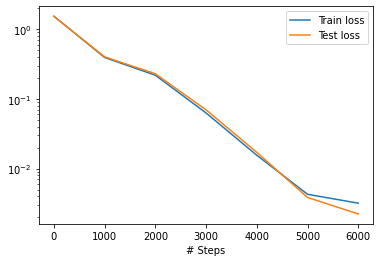

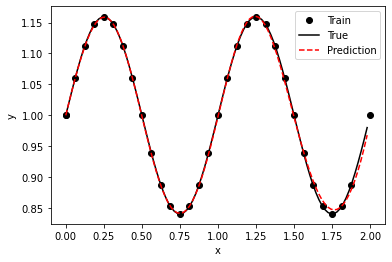

In [16]:
losshistory, train_state = model.train(epochs = 6000)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

In [17]:
import deepxde as dde
import numpy as np

In [18]:
def ddy(x, y):
    return dde.grad.hessian(y, x)

def dddy(x, y):
    return dde.grad.jacobian(ddy(x, y), x)

def pde(x, y):
    dy_xx = ddy(x, y)
    dy_xxxx = dde.grad.hessian(dy_xx, x)
    return dy_xxxx + 1

In [19]:
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

In [20]:
geom = dde.geometry.Interval(0, 1)

bc1 = dde.DirichletBC(geom, lambda x: 0, boundary_left) # u(0) = 0
bc2 = dde.NeumannBC(geom, lambda x: 0, boundary_left) # u'(0) = 0
bc3 = dde.OperatorBC(geom, lambda x, y, _: ddy(x, y), boundary_right) # u''(1) = 0
bc4 = dde.OperatorBC(geom, lambda x, y, _: dddy(x, y), boundary_right) # u'''(1) = 0

# Reference solution to compute the error
def true_solution(x):
    return -(x ** 4) / 24 + x ** 3 / 6 - x ** 2 / 4

data = dde.data.PDE(geom, 
                    pde, 
                    [bc1, bc2, bc3, bc4], 
                    num_domain = 10, 
                    num_boundary = 2, 
                    solution = true_solution, 
                    num_test = 100)

In [21]:
layer_size = [1] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)

In [22]:
model = dde.Model(data, net)
model.compile("adam", lr = 0.001)

Compiling model...
Building feed-forward neural network...
'build' took 0.090267 s



/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 5.582687 s



Initializing variables...
Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [6.95e+00, 0.00e+00, 7.76e-01, 2.10e-01, 7.90e-02]    [7.28e+00, 0.00e+00, 7.76e-01, 2.10e-01, 7.90e-02]    []  
1000      [7.37e-03, 1.43e-06, 4.66e-04, 5.31e-03, 7.22e-04]    [4.58e-03, 1.43e-06, 4.66e-04, 5.31e-03, 7.22e-04]    []  
2000      [2.70e-04, 3.36e-09, 7.17e-07, 5.18e-06, 2.35e-06]    [2.06e-04, 3.36e-09, 7.17e-07, 5.18e-06, 2.35e-06]    []  
3000      [1.00e-04, 4.07e-10, 1.49e-08, 2.33e-07, 2.09e-08]    [1.20e-04, 4.07e-10, 1.49e-08, 2.33e-07, 2.09e-08]    []  
4000      [6.43e-05, 1.18e-10, 5.64e-09, 9.06e-08, 8.00e-09]    [7.95e-05, 1.18e-10, 5.64e-09, 9.06e-08, 8.00e-09]    []  
5000      [1.29e-04, 8.81e-07, 7.33e-11, 8.10e-08, 4.84e-06]    [1.17e-04, 8.81e-07, 7.33e-11, 8.10e-08, 4.84e-06]    []  

Best model at step 4000:
  train loss: 6.44e-05
  test loss: 7.96e-05
  test metric: [

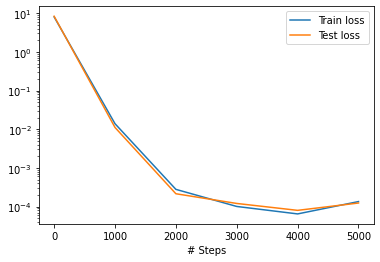

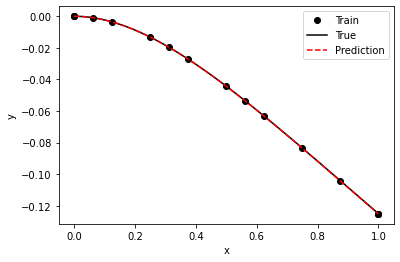

In [23]:
losshistory, train_state = model.train(epochs = 5000)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

In [24]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

In [25]:
from deepxde.backend.set_default_backend import set_default_backend
set_default_backend("tensorflow")

Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [26]:
# Properties
rho = 1
mu = 1
u_in = 1
D = 1
L = 2

In [27]:
def boundary_wall(X, on_boundary):
    on_wall = np.logical_and(np.logical_or(np.isclose(X[1], -D/2), np.isclose(X[1], D/2)), on_boundary)
    return on_wall

def boundary_inlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], -L/2)

def boundary_outlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], L/2)

In [28]:
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i = 0, j = 0)
    du_y = dde.grad.jacobian(Y, X, i = 0, j = 1)
    dv_x = dde.grad.jacobian(Y, X, i = 1, j = 0)
    dv_y = dde.grad.jacobian(Y, X, i = 1, j = 1)
    dp_x = dde.grad.jacobian(Y, X, i = 2, j = 0)
    dp_y = dde.grad.jacobian(Y, X, i = 2, j = 1)
    du_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 0)
    du_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 0)
    dv_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 1)
    dv_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 1)
    
    pde_u = Y[:,0:1]*du_x + Y[:,1:2]*du_y + 1/rho * dp_x - (mu/rho)*(du_xx + du_yy)
    pde_v = Y[:,0:1]*dv_x + Y[:,1:2]*dv_y + 1/rho * dp_y - (mu/rho)*(dv_xx + dv_yy)
    pde_cont = du_x + dv_y

    return [pde_u, pde_v, pde_cont]

In [29]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

bc_wall_u = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 0)
bc_wall_v = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 1)

bc_inlet_u = dde.DirichletBC(geom, lambda X: u_in, boundary_inlet, component = 0)
bc_inlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_inlet, component = 1)

bc_outlet_p = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 2)
bc_outlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 1)

In [30]:
data = dde.data.PDE(geom, 
                    pde, 
                    [bc_wall_u, bc_wall_v, bc_inlet_u, bc_inlet_v, bc_outlet_p, bc_outlet_v], 
                    num_domain = 2000, 
                    num_boundary = 200, 
                    num_test = 100)

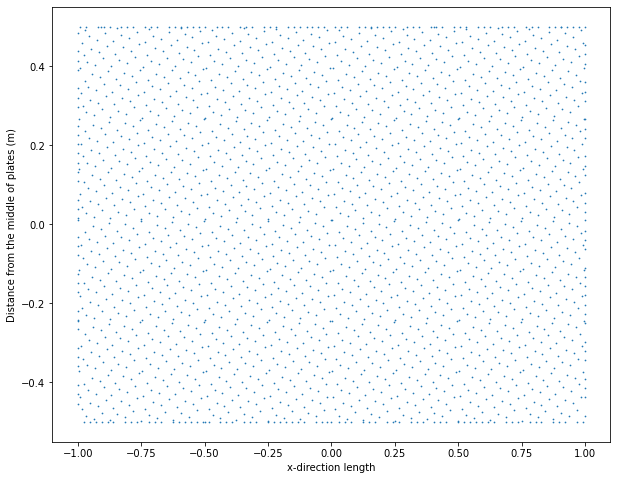

In [31]:
plt.figure(figsize = (10,8))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.5)
plt.xlabel('x-direction length')
plt.ylabel('Distance from the middle of plates (m)')
plt.show()

In [32]:
layer_size = [2] + [64] * 5 + [3]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr = 1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.086778 s



/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 1.895834 s



Initializing variables...
Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.06e-02, 5.27e-02, 1.27e-03, 1.57e-02, 1.63e-02, 1.13e+00, 3.87e-02, 2.80e-03, 3.82e-02]    [9.13e-03, 5.34e-02, 1.18e-03, 1.57e-02, 1.63e-02, 1.13e+00, 3.87e-02, 2.80e-03, 3.82e-02]    []  
1000      [1.17e-03, 8.34e-04, 8.26e-03, 2.78e-02, 1.22e-02, 3.88e-02, 3.46e-03, 3.27e-04, 9.80e-06]    [7.90e-04, 4.27e-04, 4.62e-03, 2.78e-02, 1.22e-02, 3.88e-02, 3.46e-03, 3.27e-04, 9.80e-06]    []  
2000      [8.40e-04, 5.39e-04, 4.22e-03, 2.23e-02, 8.33e-03, 3.32e-02, 7.03e-04, 1.33e-04, 3.00e-05]    [3.42e-04, 2.28e-04, 1.93e-03, 2.23e-02, 8.33e-03, 3.32e-02, 7.03e-04, 1.33e-04, 3.00e-05]    []  
3000      [1.50e-03, 1.12e-03, 3.38e-03, 1.97e-02, 7.13e-03, 2.71e-02, 1.02e-03, 4.59e-05, 3.80e-05]    [1.11e-03, 8.17e-04, 1.22e-03, 1

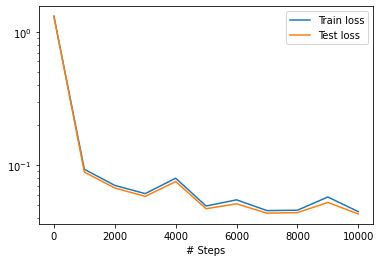

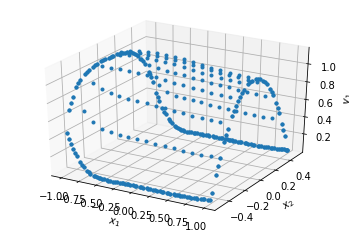

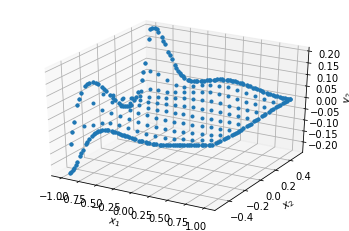

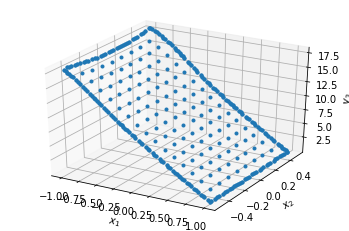

In [33]:
losshistory, train_state = model.train(epochs = 10000)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

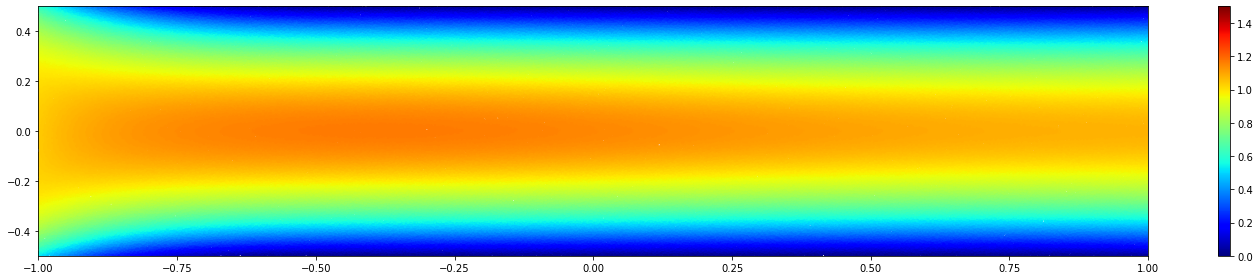

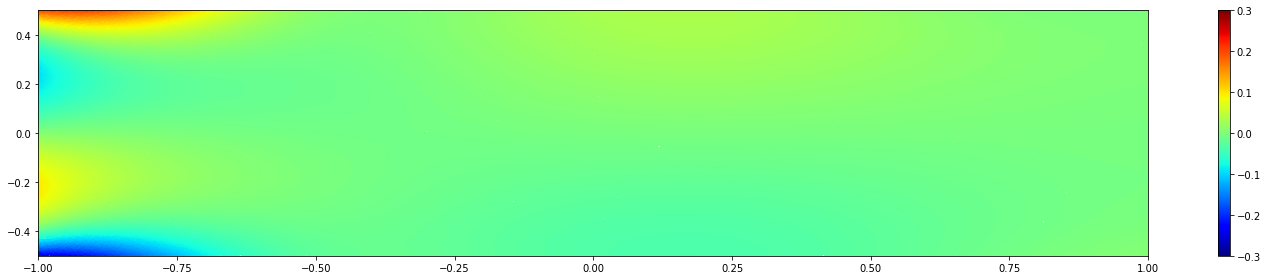

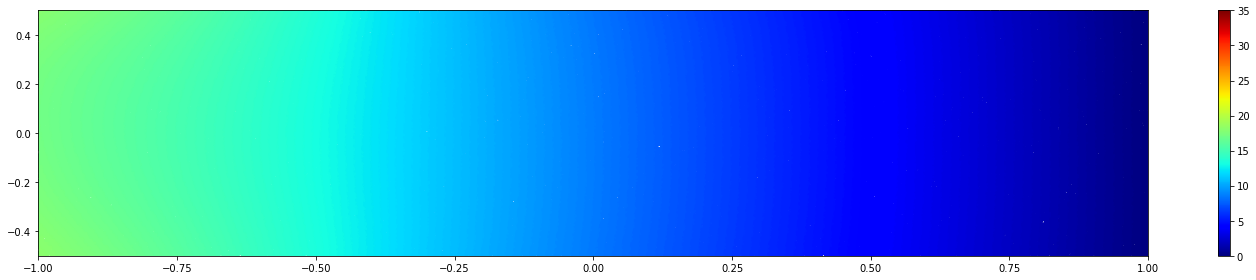

In [34]:
samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize = (20, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],
                c = result[:, idx],
                cmap = 'jet',
                s = 2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.show()

Compiling model...
'compile' took 1.124358 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
10000     [8.55e-04, 2.55e-04, 2.11e-03, 1.44e-02, 5.38e-03, 1.50e-02, 5.37e-03, 1.28e-03, 9.03e-06]    [6.78e-04, 1.46e-04, 6.50e-04, 1.44e-02, 5.38e-03, 1.50e-02, 5.37e-03, 1.28e-03, 9.03e-06]    []  
11000     [7.75e-04, 8.98e-04, 1.16e-03, 7.62e-03, 1.17e-03, 6.02e-03, 1.55e-03, 1.65e-05, 2.03e-06]                                                                                                      
12000     [4.67e-04, 3.94e-04, 4.75e-04, 4.57e-03, 1.09e-03, 4.49e-03, 1.35e-03, 2.26e-05, 9.54e-06]                                                                                                      
13000     [4.12e-04, 4.41e-04, 4.27e-04, 3.41e-03, 1.06e-03, 3.25e-03, 1.10e-03, 6.13e-06, 2.49e-06]                

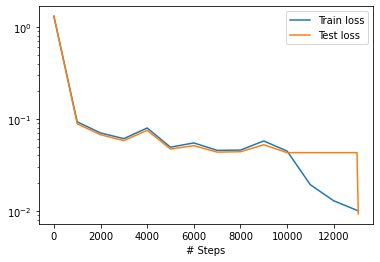

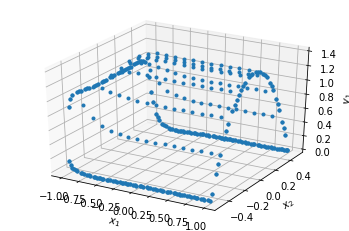

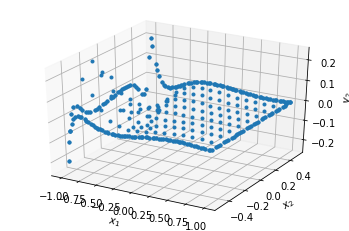

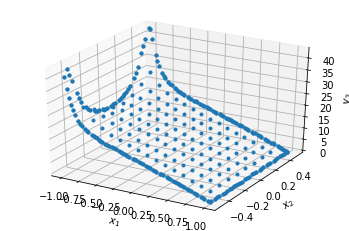

In [35]:
dde.optimizers.config.set_LBFGS_options(maxiter = 3000)

model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

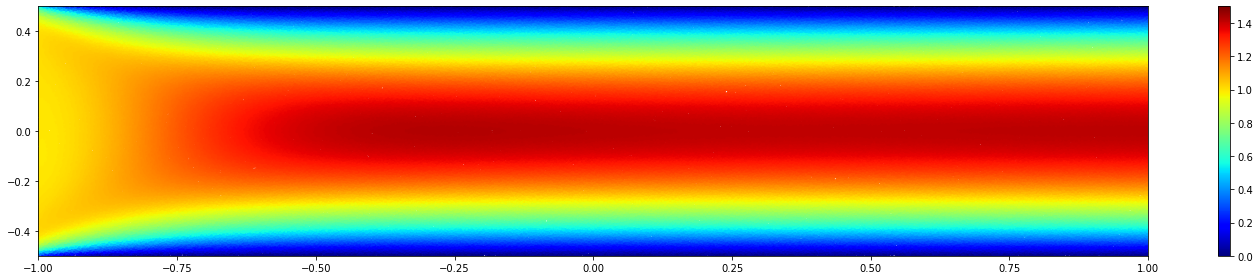

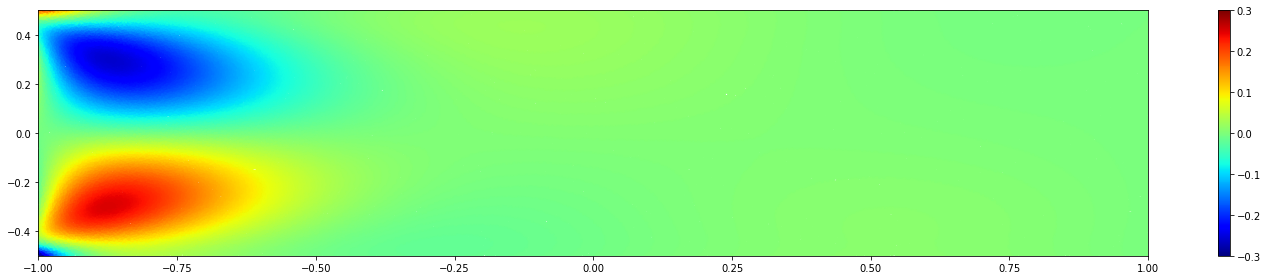

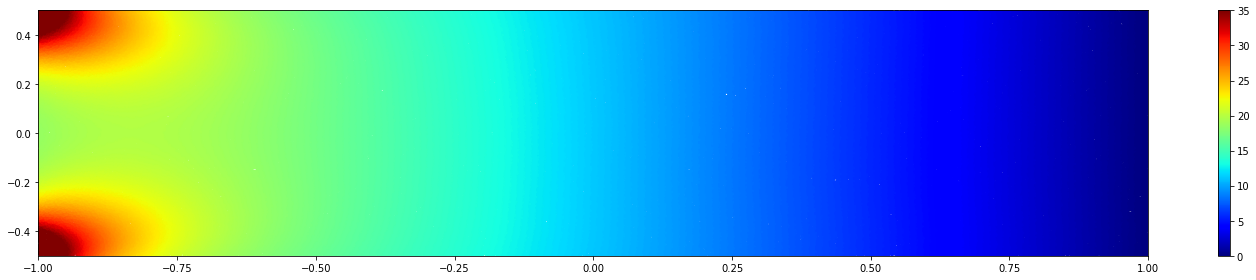

In [36]:
samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize = (20, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],
                c = result[:, idx],
                cmap = 'jet',
                s = 2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.show()

In [37]:
# Analytic solution
x = np.ones([1000,1])
y = np.linspace(-0.5, 0.5, 1000).reshape(1000,1)
outlet = np.hstack([x, y])

analytic_solution = u_in * 1.5 * (1 - ((y)/(D/2))**2)

PINN_solution = model.predict(outlet)

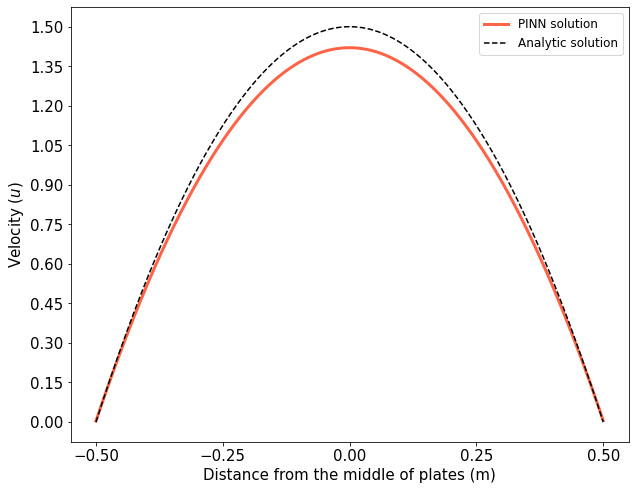

In [38]:
plt.figure(figsize = (10,8))
plt.plot(y, PINN_solution[:, 0], c = 'tomato', linewidth = 3, label = 'PINN solution')
plt.plot(y, analytic_solution, c = 'k', linestyle = '--', label = 'Analytic solution')
plt.xticks(np.linspace(-0.5, 0.5, 5), fontsize = 15)
plt.yticks(np.linspace(0, 1.5, 11), fontsize = 15)
plt.legend(fontsize = 12)
plt.xlabel('Distance from the middle of plates (m)', fontsize = 15)
plt.ylabel('Velocity ($u$)', fontsize = 15)
plt.show()